In [1]:
import pandas as pd
import geopandas as gpd
import math
import numpy as np
import seaborn as sns
from sklearn import linear_model
from matplotlib import pyplot
import pyproj
from scipy.stats import median_abs_deviation
import seaborn as sns

# 1. Load data
The dataframe was made in Notebook nr 6

In [2]:
df_year = gpd.read_file('..\\Data\\icesat2_polygons\\atl08_polygons.gpkg', layer= 'gap_fractions_YEAR')

df_year['can_pho_gap_atl08'] = 1 - (df_year['n_can_pho'] + df_year['n_topcan_pho'])/(df_year['n_can_pho'] + df_year['n_topcan_pho']+df_year['n_ter_pho'])
df_year['h_dif_als'] = df_year['ALS_98_h']-df_year['can_h']
print('size of combined df: ', len(df_year.index))

size of combined df:  32024


In [3]:
# add season
df_year['s'] = 'nan'

for iindex, row in df_year.iterrows():
    if row['month'] in ['05', '06', '07', '08', '09']:
        
        df_year.loc[iindex, 's'] = 'summer'
    else:
        df_year.loc[iindex, 's'] = 'winter'

In [4]:
df_year.head()

,track,seg,timestamp,year,month,beam_nr,beam_t,can_h,n_can_pho,n_topcan_pho,...,all_first,can_first,gr_first,all_last,gr_last,can_last,geometry,can_pho_gap_atl08,h_dif_als,s
0,gt3l,682148,7.610986e+07,2020,05,5,strong,17.083992,82,5,...,590.0,226.0,153.0,599.0,279.0,0.0,"MULTIPOLYGON (((651208.109 6377776.104, 651220...",0.613333,-1.143992,summer
1,gt1l,319685,5.028289e+07,2019,08,1,strong,24.607330,121,11,...,550.0,194.0,194.0,546.0,246.0,0.0,"MULTIPOLYGON (((651907.675 6377773.069, 651895...",0.312500,1.902670,summer
2,gt1l,319690,5.028289e+07,2019,08,1,strong,28.583214,104,32,...,587.0,366.0,17.0,589.0,143.0,0.0,"MULTIPOLYGON (((651894.163 6377872.448, 651882...",0.139241,0.266786,summer
3,gt1l,319649,7.382326e+07,2020,05,6,weak,11.164398,37,42,...,755.0,187.0,432.0,750.0,490.0,0.0,"MULTIPOLYGON (((655839.081 6377600.937, 655827...",0.070588,7.665602,summer
4,gt1l,319654,7.382326e+07,2020,05,6,weak,30.432213,67,8,...,650.0,394.0,73.0,643.0,233.0,0.0,"MULTIPOLYGON (((655825.479 6377700.254, 655813...",0.305556,0.907787,summer


## Plot ATL08 canopy height against ALS 

Root Mean Square Error before filtering:  6.2449177391382875
Median height difference:  h_dif_als    0.754246
dtype: float64
MAD before filtering:  h_dif_als    1.86366
dtype: float64
% of points within 2 m:  64.35173619785161
% of points within 3 m:  71.99288033974518
R squared:  0.39382054032575864
Root Mean Square Error after filtering:  4.421536062993594
Median height difference:  h_dif_als    0.520778
dtype: float64
MAD after filtering:  h_dif_als    1.360326
dtype: float64
% of points within 2 m:  72.2015881147541
% of points within 3 m:  80.75051229508196


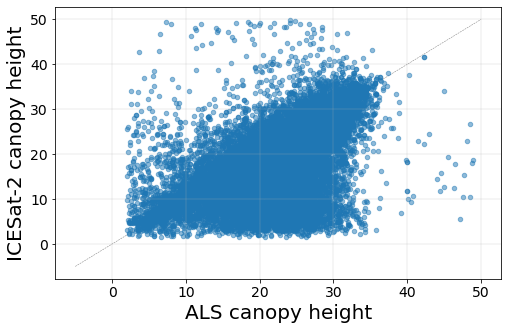

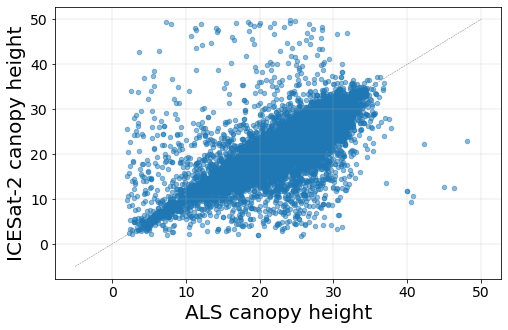

In [5]:
fig, ax = pyplot.subplots(figsize=(8,5))
df_year.plot.scatter( x = 'ALS_98_h', y = 'can_h', xlabel = 'ALS canopy height', ax=ax, alpha = 0.5,  fontsize=12)
ax.set_ylabel('ICESat-2 canopy height', fontdict={'fontsize':20})
ax.set_xlabel('ALS canopy height', fontdict={'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=14)
line = np.linspace(-5, 50, 100)
x_line = np.linspace(-5, 50, 100)
ax.plot(line, x_line, zorder=-1, color = 'grey', linewidth=0.5, linestyle='--')
ax.grid('on', linestyle='-', linewidth=0.25 )

MSE = np.square(np.subtract(df_year['ALS_98_h'], df_year['can_h'])).mean()
RMSE = math.sqrt(MSE)
print("Root Mean Square Error before filtering: ", RMSE)
print("Median height difference: ", df_year[['h_dif_als']].median())
print("MAD before filtering: ", df_year[['h_dif_als']].apply(median_abs_deviation))
under2 = df_year[df_year['h_dif_als'].lt(2)]
under3 = df_year[df_year['h_dif_als'].lt(3)]
print("% of points within 2 m: ", len(under2.index)*100/len(df_year.index))
print("% of points within 3 m: ", len(under3.index)*100/len(df_year.index))

#initiate linear regression model
model = linear_model.LinearRegression()
X, y = df_year[["can_h"]], df_year.ALS_98_h
#fit regression model
model.fit(X, y)
#calculate R-squared of regression model
r_squared = model.score(X, y)
#view R-squared value
print('R squared: ', r_squared)
#pyplot.savefig('plots\\als_atl_heights_all.png', bbox_inches='tight')

# ---------------------------------------------------------------------------------------
# filter out all daytime data 
df = df_year[df_year['solar_el'].lt(0)]
fig2, ax2 = pyplot.subplots(figsize=(8,5))

df.plot.scatter( x = 'ALS_98_h', y = 'can_h', xlabel = 'ALS canopy height', ylabel = 'ICESat-2 canopy height', ax=ax2, alpha = 0.5)
ax2.set_ylabel('ICESat-2 canopy height', fontdict={'fontsize':20})
ax2.set_xlabel('ALS canopy height', fontdict={'fontsize':20})
ax2.tick_params(axis='both', which='major', labelsize=14)
line = np.linspace(-5, 50, 100)
x_line = np.linspace(-5, 50, 100)
ax2.plot(line, x_line, zorder=-1, color = 'grey', linewidth=0.5, linestyle='--')
ax2.grid('on', linestyle='-', linewidth=0.25 )
#ax.grid('on', which='major', axis='x' )
MSE = np.square(np.subtract(df['ALS_98_h'], df['can_h'])).mean()
RMSE = math.sqrt(MSE)
print("Root Mean Square Error after filtering: ", RMSE)
print("Median height difference: ", df[['h_dif_als']].median())
print("MAD after filtering: ", df[['h_dif_als']].apply(median_abs_deviation))
under2 = df[df['h_dif_als'].lt(2)]
under3 = df[df['h_dif_als'].lt(3)]
print("% of points within 2 m: ", len(under2.index)*100/len(df.index))
print("% of points within 3 m: ", len(under3.index)*100/len(df.index))
#pyplot.savefig('plots\\als_atl_heights_night.png', bbox_inches='tight')

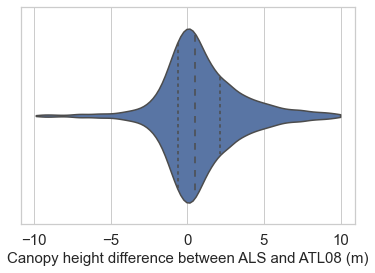

In [6]:
sns.set_theme(style="whitegrid")
vplot = sns.violinplot(data=df[abs(df['h_dif_als']).lt(10)], x='h_dif_als', cut = 0.0,
               split=False, inner="quartile", linewidth=1.5)#,
vplot.set_xlabel("Canopy height difference between ALS and ATL08 (m)", fontsize=15)
vplot.tick_params(labelsize=15)
#pyplot.savefig('plots\\heights_violin.png', bbox_inches='tight')



# Canopy gap fraction

In [7]:
# ratio from radiometric profile
ratio = 1.8/2.3

df_year['ice_gap'] = 1-1/(1 + ratio * df_year['ter_pho_rate']/df_year['can_pho_rate'])
df_year['ALS_dns_gap'] = df_year['ALS_dns_gap']/100

In [8]:
df_year = df_year[df_year['can_pho_gap_atl08'].lt(1)]
df_year = df_year[df_year['can_pho_gap_atl08'].gt(0)]

df_year = df_year[df_year['ALS_dns_gap'].lt(1)]
df_year = df_year[df_year['ALS_dns_gap'].gt(0)]
df_year = df_year[df_year['ice_gap'].lt(1)]
df_year = df_year[df_year['ice_gap'].gt(0)]

In [9]:
pd.set_option('display.max_columns',None)
# small df for easier processing
small_df = df_year[['can_pho_gap_atl08','ice_gap', 'ALS_dns_gap', 'SCI','species_majority', 'species_variety',  'ALS_av_h', 'can_h', 'month', 'beam_t', 's', 'solar_el', 'h_dif_als']]


In [10]:
small_df.head()

,can_pho_gap_atl08,ice_gap,ALS_dns_gap,SCI,species_majority,species_variety,ALS_av_h,can_h,month,beam_t,s,solar_el,h_dif_als
0,0.613333,0.553846,0.360,0.385781,0.0,2.0,9.95,17.083992,05,strong,summer,-10.199727,-1.143992
1,0.312500,0.262391,0.369,0.461538,11.0,2.0,16.98,24.607330,08,strong,summer,-14.277411,1.902670
2,0.139241,0.112372,0.132,0.120050,12.0,1.0,19.05,28.583214,08,strong,summer,-14.276580,0.266786
3,0.070588,0.056104,0.523,0.677285,0.0,1.0,9.89,11.164398,05,weak,summer,48.535610,7.665602
4,0.305556,0.256145,0.220,0.250693,12.0,2.0,19.07,30.432213,05,weak,summer,48.534721,0.907787


# Canopy gap fraction in different forest types

[Text(0, 0, 'Un- \n known\n 4615'),
 Text(1, 0, 'Sparse\n 3964'),
 Text(2, 0, 'Birch\n 3598'),
 Text(3, 0, 'Spruce\n 2374'),
 Text(4, 0, 'Pine\n 1053'),
 Text(5, 0, 'G-Alder\n 666'),
 Text(6, 0, 'B-Alder\n 335'),
 Text(7, 0, 'Aspen\n 115'),
 Text(8, 0, 'Ash\n 2'),
 Text(9, 0, 'Other\n 2')]

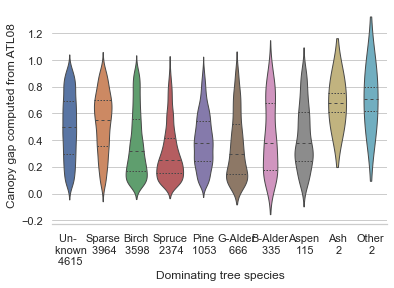

In [11]:
species = small_df[small_df['s'].eq('summer')]
ax = sns.violinplot(data=species, x='species_majority', y="can_pho_gap_atl08", 
               split=False, inner="quart", linewidth=1)#,
               #palette={"Yes": "b", "No": ".85"})
#ax.set_xticklabels(['n/a', 'Sparse', 'Birch', 'Spruce', 'Pine', 'G-Alder', 'B-Alder', 'Aspen', 'Ash', 'Other'])
ax.set(xlabel='Dominating tree species', ylabel='Canopy gap computed from ATL08')
sns.despine(left=True)

nobs = species['species_majority'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
sp = ['n/a', 'Sparse', 'Birch', 'Spruce', 'Pine', 'G-Alder', 'B-Alder', 'Aspen', 'Ash', 'Other']
nobs = ['\n ' + i for i in nobs]
ax.set_xticklabels(['Un- \n known' + nobs[0], 'Sparse' + nobs[1], 'Birch' + nobs[2], 'Spruce' + nobs[3], 
                    'Pine' + nobs[4], 'G-Alder' + nobs[5], 'B-Alder' + nobs[6], 'Aspen' + nobs[7], 'Ash' + nobs[8], 'Other' + nobs[9]])

#pyplot.savefig('plots\\atl08_gap_species_violin.png', bbox_inches='tight')

# Canopy gap fraction through year

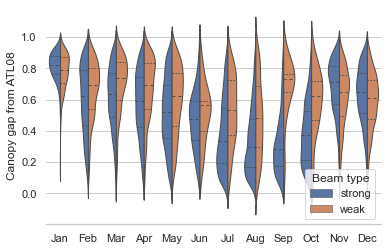

In [12]:
#import seaborn as sns
sns.set_theme(style="whitegrid")
# Draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=small_df[small_df['solar_el'].lt(0)], x='month', y="can_pho_gap_atl08", hue="beam_t",
               split=True, inner="quart", linewidth=1, order = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])#,
               #palette={"Yes": "b", "No": ".85"})

# Calculate number of obs per group & median to position labels
nobs = small_df[small_df['solar_el'].lt(0)]['month'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ['\n ' + i for i in nobs]
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 
                    'Dec'])
ax.set(xlabel = '', ylabel='Canopy gap from ATL08')

ax.legend(title='Beam type', loc='lower right') # labels=['Hell Yeh', 'Nah Bruh']
sns.despine(left=True)
#pyplot.savefig('plots\\ices_gap_months_violin.png',dpi=300, bbox_inches = "tight")


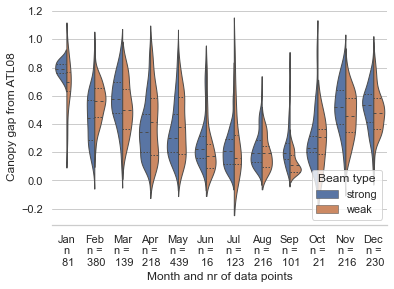

In [13]:
# annual for spurce only
spruce = small_df[small_df['species_majority'].eq(12)]
spruce = spruce[spruce['h_dif_als'].lt(5)]
spruce = spruce[spruce['species_variety'].eq(1.0)]
#spruce = spruce[abs(spruce['h_dif_als']).lt(3)]
ax = sns.violinplot(data=spruce, x='month', y="can_pho_gap_atl08", hue="beam_t",
               split=True, inner="quart", linewidth=1, order = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

# Calculate number of obs per group & median to position labels
nobs = spruce['month'].value_counts()#.values
nobs = nobs.values
nobs = [str(x) for x in nobs.tolist()]
nobs = ['\n ' + i for i in nobs]

ax.set_xticklabels(['Jan\nn' + nobs[9], 'Feb\nn ='+ nobs[1], 'Mar\nn ='+ nobs[6], 'Apr\nn ='+ nobs[3], 'May\nn ='+ nobs[0], 'Jun\nn ='+ nobs[11], 
                    'Jul\nn ='+ nobs[7], 'Aug\nn ='+ nobs[4], 'Sep\nn ='+ nobs[8], 'Oct\nn ='+ nobs[10], 'Nov\nn ='+ nobs[5], 
                    'Dec\nn ='+ nobs[2]])
ax.set(xlabel='Month and nr of data points', ylabel='Canopy gap from ATL08')

ax.legend(title='Beam type', loc='lower right') # labels=['Hell Yeh', 'Nah Bruh']
sns.despine(left=True)
#pyplot.savefig('plots\\ices_gap_months_spruce_violin.png',dpi=300, bbox_inches = "tight")


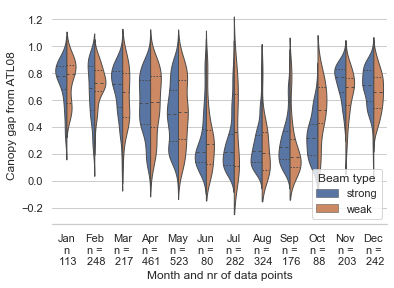

In [14]:
# annual for birch only
birch = small_df[small_df['species_majority'].eq(11)]
birch = birch[birch['h_dif_als'].lt(5)]
birch = birch[birch['species_variety'].eq(1.0)]

ax = sns.violinplot(data=birch, x='month', y="can_pho_gap_atl08", hue="beam_t",
               split=True, inner="quart", linewidth=1, order = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])
               #palette={"Yes": "b", "No": ".85"})

# Calculate number of obs per group & median to position labels
nobs = birch['month'].value_counts()#.values
nobs = nobs.values
nobs = [str(x) for x in nobs.tolist()]
nobs = ['\n ' + i for i in nobs]
ax.set_xticklabels(['Jan\nn' + nobs[9], 'Feb\nn ='+ nobs[4], 'Mar\nn ='+ nobs[6], 'Apr\nn ='+ nobs[1], 'May\nn ='+ nobs[0], 'Jun\nn ='+ nobs[11], 
                    'Jul\nn ='+ nobs[3], 'Aug\nn ='+ nobs[2], 'Sep\nn ='+ nobs[8], 'Oct\nn ='+ nobs[10], 'Nov\nn ='+ nobs[7], 
                    'Dec\nn ='+ nobs[5]])
ax.set(xlabel='Month and nr of data points', ylabel='Canopy gap from ATL08')

ax.legend(title='Beam type', loc='lower right') # labels=['Hell Yeh', 'Nah Bruh']
sns.despine(left=True)
#pyplot.savefig('plots\\ices_gap_months_birch_violin.png',dpi=300, bbox_inches = "tight")


# Analyse the canopy gap fraction from ATL08 and ALS

Root Mean Square Error before filtering:  0.23956044739182322
Median difference:  0.15580456884887262
MAD:  can_pho_gap_atl08    0.211689
dtype: float64


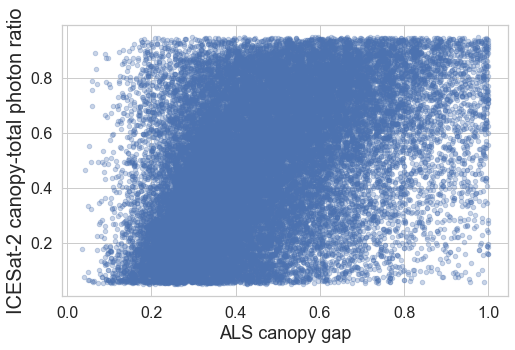

In [15]:
fig, ax = pyplot.subplots(figsize=(8,5))
small_df.plot.scatter(x  = 'ALS_dns_gap', y = 'can_pho_gap_atl08',
                      xlabel = 'ALS canopy gap', ylabel = 'ICESat-2 canopy-total photon ratio', ax=ax, alpha = 0.3,
                     )
ax.set_ylabel('ICESat-2 canopy-total photon ratio', fontdict={'fontsize':20})
ax.set_xlabel('ALS canopy gap', fontdict={'fontsize':18})
ax.tick_params(axis='both', which='major', labelsize=16)
MSE = np.square(np.subtract(small_df['ALS_dns_gap'], small_df['can_pho_gap_atl08'])).mean()
RMSE = math.sqrt(MSE)
print("Root Mean Square Error before filtering: ", RMSE)
dif = small_df['ALS_dns_gap']-small_df['can_pho_gap_atl08']
print("Median difference: ", abs(small_df['ALS_dns_gap']-small_df['can_pho_gap_atl08']).median())
print("MAD: ", small_df[['can_pho_gap_atl08']].apply(median_abs_deviation))

#pyplot.savefig('plots\\als_dnsgap_phoratio_all_scatter.png', bbox_inches='tight')

In [ ]:
fig, ax = pyplot.subplots(figsize=(8,5))
small_df.plot.scatter(x  = 'SCI', y = 'can_pho_gap_atl08',
                      xlabel = 'ALS SCI', ylabel = 'ICESat-2 canopy-total photon ratio', ax=ax, alpha = 0.3,
                     )
ax.set_ylabel('ICESat-2 canopy-total photon ratio', fontdict={'fontsize':20})
ax.set_xlabel('ALS SCI', fontdict={'fontsize':18})
MSE = np.square(np.subtract(small_df['SCI'], small_df['can_pho_gap_atl08'])).mean()
RMSE = math.sqrt(MSE)
print("Root Mean Square Error before filtering: ", RMSE)
#dif = small_df['SCI']-small_df['can_pho_gap_atl08']
print("Median difference: ", abs(small_df['SCI']-small_df['can_pho_gap_atl08']).median())
print("MAD: ", small_df[['can_pho_gap_atl08']].apply(median_abs_deviation))

#pyplot.savefig('plots\\als_sci_phoratio_all_scatter.png', bbox_inches='tight')

In [ ]:
fig, ax = pyplot.subplots(figsize=(8,5))
small_df.plot.scatter(x  = 'ALS_dns_gap', y = 'ice_gap',
                      ax=ax, alpha = 0.3,
                     )
ax.set_ylabel('ICESat-2 canopy gap', fontdict={'fontsize':20})
ax.set_xlabel('ALS canopy gap', fontdict={'fontsize':18})
ax.tick_params(axis='both', which='major', labelsize=16)

MSE = np.square(np.subtract(small_df['ALS_dns_gap'], small_df['ice_gap'])).mean()
RMSE = math.sqrt(MSE)
print("Root Mean Square Error before filtering: ", RMSE)

print("Median difference: ", abs(small_df['ALS_dns_gap']-small_df['ice_gap']).median())
print("MAD: ", small_df[['ice_gap']].apply(median_abs_deviation))

#pyplot.savefig('plots\\als_atl_dnsgap_all_scatter.png', bbox_inches='tight')

In [ ]:
fig, ax = pyplot.subplots(figsize=(8,5))
small_df.plot.scatter(x  = 'SCI', y = 'ice_gap',
                      ax=ax, alpha = 0.3,
                     )
ax.set_ylabel('ICESat-2 canopy gap', fontdict={'fontsize':20})
ax.set_xlabel('ALS SCI', fontdict={'fontsize':18})
MSE = np.square(np.subtract(small_df['SCI'], small_df['ice_gap'])).mean()
RMSE = math.sqrt(MSE)
print("Root Mean Square Error before filtering: ", RMSE)
print("Median difference: ", abs(small_df['SCI']-small_df['ice_gap']).median())
print("MAD: ", small_df[['ice_gap']].apply(median_abs_deviation))

#pyplot.savefig('plots\\als_atl_SCI_all_scatter.png', bbox_inches='tight')